13. Same of 6th model but uses fovea heatmaps and same LR for feature and classifier


In [1]:
# train_mobilenet_with_fovea.py
# Complete script: MobileNetV3-Large classification + fovea heatmap as extra channel

import os, sys, random
import torch
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError, ImageOps
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.transforms import functional as TF

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [2]:
# -----------------------
# User paths (keep as you provided)
# -----------------------
TRAIN_FOLDER = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Dataset\Train-image-400\image'
TRAIN_GT_TXT = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Dataset\Train-image-400\train_classification_GT.txt'
VAL_FOLDER   = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Dataset\Validation-image-400\image'
VAL_GT_TXT   = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Dataset\Validation-image-400\validation_classification_GT.txt'
FOVEA_XLSX   = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Dataset\Train-image-400\Fovea_location-name.xlsx'
SAVE_BASE    = r'C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Checkpoints\Fourteenth_Model'   # checkpoints will be saved here

os.makedirs(SAVE_BASE, exist_ok=True)

# quick checks
print("Check existence:")
print("TRAIN_FOLDER exists:", os.path.exists(TRAIN_FOLDER))
print("TRAIN_GT_TXT exists:", os.path.exists(TRAIN_GT_TXT))
print("VAL_FOLDER exists:", os.path.exists(VAL_FOLDER))
print("VAL_GT_TXT exists:", os.path.exists(VAL_GT_TXT))
print("FOVEA_XLSX exists:", os.path.exists(FOVEA_XLSX))

Check existence:
TRAIN_FOLDER exists: True
TRAIN_GT_TXT exists: True
VAL_FOLDER exists: True
VAL_GT_TXT exists: True
FOVEA_XLSX exists: True


In [3]:
# -----------------------
# Device + reproducibility
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

# -----------------------
# Hyperparameters (kept as original)
# -----------------------
BATCH_SIZE = 32
NUM_EPOCH = 30
NUM_WORKERS = 0
PIN_MEMORY = True if device.type == "cuda" else False

FEATURE = 6
RANDOM_SAMPLING = True
FEATURE_LEARNING_RATE = 1e-3
CLASSIFIER_LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
APPLY_POS_WEIGHT = True

Using device: cuda


In [4]:
# -----------------------
# COmplexity added due to fovea heatmap channel
# Read fovea csv/xlsx -> map imgname -> (x,y)
# -----------------------
def read_fovea_xlsx(path):
    if not os.path.exists(path):
        print("Fovea file not found:", path)
        return {}
    try:
        # attempt to read with header detection
        df = pd.read_excel(path, engine='openpyxl')
    except Exception:
        df = pd.read_csv(path)
    # normalize column names (case-insensitive)
    cols = [c.strip().lower() for c in df.columns]
    # find columns
    idx_img = None; idx_x = None; idx_y = None
    for i,c in enumerate(cols):
        if 'img' in c and 'name' in c:
            idx_img = i
        if 'fovea' in c and ('x' in c or '_x' in c):
            idx_x = i
        if 'fovea' in c and ('y' in c or '_y' in c):
            idx_y = i
    # fallback search
    if idx_img is None:
        for i,c in enumerate(cols):
            if 'img' in c:
                idx_img = i
    if idx_x is None:
        for i,c in enumerate(cols):
            if 'x' in c and 'fovea' in c or c.endswith('_x') or c == 'x':
                idx_x = i
    if idx_y is None:
        for i,c in enumerate(cols):
            if 'y' in c and 'fovea' in c or c.endswith('_y') or c == 'y':
                idx_y = i
    # if still none, try first three columns
    if idx_img is None or idx_x is None or idx_y is None:
        if df.shape[1] >= 3:
            idx_img, idx_x, idx_y = 0,1,2
    res = {}
    for _, row in df.iterrows():
        img = str(row.iloc[idx_img]).strip()
        try:
            x = float(row.iloc[idx_x])
            y = float(row.iloc[idx_y])
        except Exception:
            continue
        # ensure matching filename format as in your dataset
        res[img] = (x, y)
    print(f"Loaded fovea entries: {len(res)}")
    return res

fovea_map = read_fovea_xlsx(FOVEA_XLSX)

# -----------------------
# Heatmap helper: returns numpy float32 HxW in [0,1]
# -----------------------
def make_gaussian_heatmap(size, center, sigma):
    # size: (H, W), center: (x, y) in pixels (x horizontal)
    H, W = size
    xx = np.arange(W)
    yy = np.arange(H)
    xxg, yyg = np.meshgrid(xx, yy)
    cx, cy = center
    g = np.exp(-((xxg - cx)**2 + (yyg - cy)**2) / (2.0 * (sigma**2)))
    g = g.astype(np.float32)
    if g.max() > 0:
        g = (g - g.min()) / (g.max() - g.min() + 1e-9)
    return g

# -----------------------
# Custom dataset that returns (4-channel tensor, label)
#  - keeps your augmentations but ensures geometric transforms also applied to heatmap
# -----------------------
class CustomImageDatasetWithFovea(Dataset):
    def __init__(self, img_folder, label_file, fovea_map,
                 train=True, mean=None, std=None):
        self.image_folder = img_folder
        self.transform_train = None
        self.transform_test = None
        self.img_labels = []
        self.fovea_map = fovea_map
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    img_name, label = parts[0], parts[1]
                    self.img_labels.append((img_name, int(label)))
        # Precompute normalization params
        self.mean = mean if mean is not None else [0.485, 0.456, 0.406]
        self.std  = std  if std  is not None else [0.229, 0.224, 0.225]
        self.train = train

        # We'll reproduce your augment pipeline with functional transforms to keep alignment
        # no external library required

    def __len__(self):
        return len(self.img_labels)

    def _pad_and_adjust(self, img, fovea_xy):
        # pad to square and adjust fovea coords accordingly
        w, h = img.size
        if w == h:
            return img, fovea_xy
        if w > h:
            delta = w - h
            pad = (0, delta//2, 0, delta - delta//2)  # left, top, right, bottom
        else:
            delta = h - w
            pad = (delta//2, 0, delta - delta//2, 0)
        img_p = ImageOps.expand(img, pad)
        if fovea_xy is None:
            return img_p, None
        fx, fy = fovea_xy
        fx_new = fx + pad[0]
        fy_new = fy + pad[1]
        return img_p, (fx_new, fy_new)

    def _resize(self, img, size, fovea_xy):
        # size: (H, W) or (W, H) depending on PIL usage; we will pass (W,H) via tuple
        orig_w, orig_h = img.size
        new_w, new_h = size
        img_r = img.resize((new_w, new_h), resample=Image.BILINEAR)
        if fovea_xy is None:
            return img_r, None
        fx, fy = fovea_xy
        fx_new = fx * (new_w / orig_w)
        fy_new = fy * (new_h / orig_h)
        return img_r, (fx_new, fy_new)

    def _random_resized_crop(self, img, fovea_xy, size=(224,224), scale=(0.85,1.0), ratio=(0.95,1.05)):
        # replicate torchvision.transforms.RandomResizedCrop.get_params
        W, H = img.size
        area = W * H
        for _ in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (np.log(ratio[0]), np.log(ratio[1]))
            aspect_ratio = np.exp(random.uniform(*log_ratio))
            w = int(round(np.sqrt(target_area * aspect_ratio)))
            h = int(round(np.sqrt(target_area / aspect_ratio)))
            if w <= W and h <= H:
                i = random.randint(0, H - h)
                j = random.randint(0, W - w)
                img_c = img.crop((j, i, j + w, i + h))
                img_resized = img_c.resize((size[0], size[1]), Image.BILINEAR)
                if fovea_xy is None:
                    return img_resized, None
                fx, fy = fovea_xy
                # if fovea outside crop, coords will be negative or >size - that's ok
                fx_c = fx - j
                fy_c = fy - i
                fx_new = fx_c * (size[0] / w)
                fy_new = fy_c * (size[1] / h)
                return img_resized, (fx_new, fy_new)
        # fallback to central crop & resize
        in_ratio = W / H
        if in_ratio < min(ratio):
            w = W
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = H
            w = int(round(h * max(ratio)))
        else:
            w = W; h = H
        i = (H - h) // 2
        j = (W - w) // 2
        img_c = img.crop((j, i, j + w, i + h)).resize((size[0], size[1]), Image.BILINEAR)
        if fovea_xy is None:
            return img_c, None
        fx_c = fovea_xy[0] - j
        fy_c = fovea_xy[1] - i
        fx_new = fx_c * (size[0] / w)
        fy_new = fy_c * (size[1] / h)
        return img_c, (fx_new, fy_new)
    
    def _random_rotation(self, img, fovea_xy, degrees=5):
        """
    Rotate using PIL.Image.rotate (which accepts resample=Image.BILINEAR).
    Update fovea coordinate by rotating the point around the image center
    by the same angle (PIL rotates counter-clockwise for positive angles).
    """ 
        angle = random.uniform(-degrees, degrees)  # degrees, CCW positive
        # PIL rotate
        img_r = img.rotate(angle, resample=Image.BILINEAR)
        if fovea_xy is None:
            return img_r, None

        # rotate point about image center by +angle (counter-clockwise)
        w, h = img.size
        cx, cy = w / 2.0, h / 2.0
        fx, fy = fovea_xy
        tx = fx - cx
        ty = fy - cy
        theta = np.deg2rad(angle)   # positive angle -> CCW rotation
        rx = tx * np.cos(theta) - ty * np.sin(theta)
        ry = tx * np.sin(theta) + ty * np.cos(theta)
        fx_new = rx + cx
        fy_new = ry + cy
        return img_r, (fx_new, fy_new)


    def _random_affine_translate(self, img, fovea_xy, translate=(0.02,0.02)):
        """
    Apply a small translation using PIL.Image.transform (AFFINE).
    Update fovea coordinates by the same translation (dx, dy).
    """
        max_dx = int(round(translate[0] * img.size[0]))
        max_dy = int(round(translate[1] * img.size[1]))
        dx = random.randint(-max_dx, max_dx)
        dy = random.randint(-max_dy, max_dy)

        # PIL affine transform parameters: (a, b, c, d, e, f) mapping:
        # x' = a*x + b*y + c
        # y' = d*x + e*y + f
        # For pure translation: a=1,b=0,c=dx; d=0,e=1,f=dy
        img_t = img.transform(img.size, Image.AFFINE, (1, 0, dx, 0, 1, dy), resample=Image.BILINEAR)

        if fovea_xy is None:
            return img_t, None

        fx, fy = fovea_xy
        fx_new = fx + dx
        fy_new = fy + dy
        return img_t, (fx_new, fy_new)

    def _to_tensor_and_normalize(self, pil_img, mean, std):
        # pil_img is RGB PIL
        t = TF.to_tensor(pil_img)  # float 0..1 as tensor CxHxW
        t = TF.normalize(t, mean=mean, std=std)
        return t

    def _heatmap_to_tensor(self, heatmap_np):
        # heatmap_np: HxW float32 normalized 0..1
        t = torch.from_numpy(heatmap_np).unsqueeze(0)  # 1xHxW
        t = t.float()
        return t

    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.image_folder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError) as e:
            print(f"Warning: unable to open {img_path}: {e}. Returning black image.")
            image = Image.new('RGB', (224, 224), (0,0,0))
        # get fovea coords (in original image pixel coordinates)
        fov = None
        if img_name in self.fovea_map:
            fov = self.fovea_map[img_name]
        # --- apply geometric transforms in same way to image and heatmap coords ---
        # padding -> resize(256,256) -> RandomResizedCrop(224) -> RandomRotation(5) -> RandomAffine(translate)
        # These will be same as your pipeline's geometric steps.
        # 1) padding to square
        image_p, fov_p = self._pad_and_adjust(image, fov)
        # 2) Resize to 256x256 (note your pipeline had Resize((256,256)) BEFORE RandomResizedCrop)
        image_r, fov_r = self._resize(image_p, (256,256), fov_p)
        if self.train:
            # 3) RandomResizedCrop to 224x224
            image_rc, fov_rc = self._random_resized_crop(image_r, fov_r, size=(224,224), scale=(0.85,1.0), ratio=(0.95,1.05))
            # 4) RandomRotation 5 degrees
            image_rot, fov_rot = self._random_rotation(image_rc, fov_rc, degrees=5)
            # 5) RandomAffine translation
            image_aff, fov_aff = self._random_affine_translate(image_rot, fov_rot, translate=(0.02,0.02))
            image_geo = image_aff
            fov_geo = fov_aff
            # Photometric / non-spatial transforms: ColorJitter, GaussianBlur -> apply only to RGB image
            # We'll mimic the rest of your torchvision pipeline
            image_ph = image_geo
            # ColorJitter
            cj = transforms.ColorJitter(brightness=0.08, contrast=0.10, saturation=0.06, hue=0.005)
            image_ph = cj(image_ph)
            # GaussianBlur
            image_ph = transforms.GaussianBlur(kernel_size=3, sigma=(0.01, 0.25))(image_ph)
            # ToTensor + Normalize
            img_t = self._to_tensor_and_normalize(image_ph, mean=self.mean, std=self.std)
            # RandomErasing operates on tensor and we apply only to RGB channels (not heatmap)
            # We'll apply RandomErasing exactly as in your pipeline
            # RandomErasing has p=0.08, scale=(0.01,0.04), ratio=(0.3,2.0)
            if random.random() < 0.08:
                re = transforms.RandomErasing(p=1.0, scale=(0.01,0.04), ratio=(0.3,2.0))
                # RandomErasing expects a tensor in [C,H,W]
                img_t = re(img_t)
            # Heatmap: generate centered at fov_geo (if exists). size matches final HxW of image tensor
            H, W = img_t.shape[1], img_t.shape[2]
            if fov_geo is not None:
                fx, fy = fov_geo
                # if fx,fy outside image after cropping they may be negative -> still produce heatmap (off-image)
                # choose sigma relative to image width
                sigma = W * 0.08
                heat = make_gaussian_heatmap((H, W), (fx, fy), sigma)
            else:
                heat = np.zeros((H, W), dtype=np.float32)
            heat_t = self._heatmap_to_tensor(heat)
            # concat -> final tensor of shape (4,H,W)
            final = torch.cat([img_t, heat_t], dim=0)
        else:
            # validation / test pipeline: deterministic
            # 1) RandomResizedCrop not used; your original 'test' pipeline did Resize((224,224))
            image_rc, fov_rc = self._resize(image_r, (224,224), fov_r)
            image_ph = image_rc
            img_t = self._to_tensor_and_normalize(image_ph, mean=self.mean, std=self.std)
            H, W = img_t.shape[1], img_t.shape[2]
            if fov_rc is not None:
                fx, fy = fov_rc
                sigma = W * 0.08
                heat = make_gaussian_heatmap((H, W), (fx, fy), sigma)
            else:
                heat = np.zeros((H, W), dtype=np.float32)
            heat_t = self._heatmap_to_tensor(heat)
            final = torch.cat([img_t, heat_t], dim=0)

        return final, label

Loaded fovea entries: 400


In [5]:
# -----------------------
# Prepare transforms mean/std using mobilenet weights (kept as original)
# -----------------------
weights = MobileNet_V3_Large_Weights.DEFAULT
mean = weights.meta.get('mean', [0.485, 0.456, 0.406])
std  = weights.meta.get('std',  [0.229, 0.224, 0.225])

# instantiate datasets
train_dataset = CustomImageDatasetWithFovea(TRAIN_FOLDER, TRAIN_GT_TXT, fovea_map, train=True, mean=mean, std=std)
test_dataset  = CustomImageDatasetWithFovea(VAL_FOLDER, VAL_GT_TXT, fovea_map, train=False, mean=mean, std=std)

labels = [l for _, l in train_dataset.img_labels]
class_counts = np.bincount(labels)
print("Class counts (train):", class_counts)

# Weighted sampler to oversample minority class (keeps your original behavior)
if RANDOM_SAMPLING:
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[l] for l in labels]
    sample_weights = torch.DoubleTensor(sample_weights)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                            num_workers=NUM_WORKERS, pin_memory= PIN_MEMORY)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=NUM_WORKERS, pin_memory= PIN_MEMORY)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory= PIN_MEMORY)

# -----------------------
# Model: load mobilenet_v3_large and adapt first conv to accept 4 channels
# -----------------------
model = models.mobilenet_v3_large(weights=weights)

# find first Conv2d in model.features and replace it
first_conv = None
first_module_idx = None
for i, m in enumerate(model.features):
    # model.features is a Sequential of nn.Modules; each might be a Sequential
    for name, sub in m.named_children():
        if isinstance(sub, nn.Conv2d):
            first_conv = sub
            parent_seq = model.features[i]
            first_module_idx = (i, name)
            break
    if first_conv is not None:
        break

# fallback: search recursively
if first_conv is None:
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break

if first_conv is None:
    raise RuntimeError("Could not find first Conv2d in MobileNetV3 model.features")

# Create new conv with 4 input channels, same out_channels, kernel, stride, padding
new_conv = nn.Conv2d(in_channels=4,
                     out_channels=first_conv.out_channels,
                     kernel_size=first_conv.kernel_size,
                     stride=first_conv.stride,
                     padding=first_conv.padding,
                     dilation=first_conv.dilation,
                     bias=(first_conv.bias is not None))

# copy weights for first 3 channels
with torch.no_grad():
    old_w = first_conv.weight.data  # shape (out, in=3, k, k)
    if old_w.shape[1] >= 3:
        new_conv.weight[:, :3, :, :].copy_(old_w[:, :3, :, :])
        # initialize 4th channel as mean of existing channels
        mean_channel = old_w.mean(dim=1, keepdim=True)
        new_conv.weight[:, 3:4, :, :].copy_(mean_channel)
    else:
        # fallback random init
        nn.init.kaiming_normal_(new_conv.weight, nonlinearity='relu')

# replace in model: search and set where the object instance was
replaced = False
for i, m in enumerate(model.features):
    for name, sub in m.named_children():
        if sub is first_conv:
            setattr(model.features[i], name, new_conv)
            replaced = True
            break
    if replaced:
        break
if not replaced:
    # try top-level replacement
    for name, sub in model.features.named_children():
        if sub is first_conv:
            setattr(model.features, name, new_conv)
            replaced = True
            break

if not replaced:
    # last resort: monkey patch by indexing into modules list (risky)
    model.features[0] = new_conv  # hope it's valid; in practice the earlier replacement should work

# freeze layers as before
for p in model.parameters():
    p.requires_grad = False
for p in model.features[FEATURE:].parameters():
    p.requires_grad = True
for p in model.classifier.parameters():
    p.requires_grad = True

# conservative head for small dataset (unchanged)
in_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),

    nn.Linear(64, 1)
)

# init weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

model.classifier.apply(init_weights)
model = model.to(device)
scaler = torch.amp.GradScaler() if device.type == "cuda" else None

# POS_WEIGHT as before
POS_WEIGHT = torch.tensor([np.sqrt(int(class_counts[0])/int(class_counts[1]))], dtype=torch.float).to(device)
if APPLY_POS_WEIGHT:
    criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT)
else:
    criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW([
    {'params': model.features[FEATURE:].parameters(), 'lr': FEATURE_LEARNING_RATE},
    {'params': model.classifier.parameters(), 'lr': CLASSIFIER_LEARNING_RATE}
], weight_decay= WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)

Class counts (train): [311  89]


In [6]:
# -----------------------
# Training loop (kept behaviorally the same)
# -----------------------
best_checkpoint = None
best_val_auc = -1.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
auc_scores = []

for epoch in range(NUM_EPOCH):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCH} Train", leave=False)
    for inputs, labels in train_iter:
        inputs = inputs.to(device, non_blocking= PIN_MEMORY)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        if scaler is not None and device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        running_correct += (preds == labels.int()).sum().item()
        running_total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = running_correct / running_total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation
    model.eval()
    val_running_loss, val_running_correct, val_running_total = 0.0, 0, 0
    val_epoch_probs, val_epoch_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking= PIN_MEMORY)
            labels = labels.to(device).float().unsqueeze(1)
            if scaler is not None and device.type == 'cuda':
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs)
            probs_np = probs.cpu().numpy().flatten()
            labels_np = labels.cpu().numpy().astype(int).flatten()
            val_epoch_probs.extend(probs_np.tolist())
            val_epoch_labels.extend(labels_np.tolist())

            preds = (probs > 0.5).int()
            val_running_correct += (preds == labels.int()).sum().item()
            val_running_total += labels.size(0)

    epoch_val_loss = val_running_loss / len(test_loader.dataset)
    epoch_val_acc = val_running_correct / val_running_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    try:
        epoch_val_auc = float(roc_auc_score(np.array(val_epoch_labels), np.array(val_epoch_probs)))
    except ValueError:
        print("Only single class in the batch; AUC undefined.")
        epoch_val_auc = float('nan')

    auc_scores.append(epoch_val_auc)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{NUM_EPOCH}] Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUC: {epoch_val_auc:.4f}")

    if (not np.isnan(epoch_val_auc)) and (epoch_val_auc >= best_val_auc):
        best_val_auc = epoch_val_auc
        best_checkpoint = model.state_dict()
        best_checkpoint_epoch = epoch + 1

print(f"New best model found at epoch {best_checkpoint_epoch} with Val AUC: {best_val_auc:.4f}")

Epoch [1/30] Train Loss: 0.7820, Train Acc: 0.6850 | Val Loss: 0.7892, Val Acc: 0.4925, Val AUC: 0.7996


Epoch [2/30] Train Loss: 0.3731, Train Acc: 0.9025 | Val Loss: 0.5967, Val Acc: 0.7275, Val AUC: 0.8993


Epoch [3/30] Train Loss: 0.2865, Train Acc: 0.9325 | Val Loss: 0.5224, Val Acc: 0.7575, Val AUC: 0.9352


Epoch [4/30] Train Loss: 0.2504, Train Acc: 0.9275 | Val Loss: 0.3698, Val Acc: 0.8950, Val AUC: 0.9518


Epoch [5/30] Train Loss: 0.1807, Train Acc: 0.9575 | Val Loss: 0.4055, Val Acc: 0.8925, Val AUC: 0.9034


Epoch [6/30] Train Loss: 0.1128, Train Acc: 0.9725 | Val Loss: 0.2923, Val Acc: 0.9225, Val AUC: 0.9524


Epoch [7/30] Train Loss: 0.1361, Train Acc: 0.9625 | Val Loss: 0.3984, Val Acc: 0.9275, Val AUC: 0.9362


Epoch [8/30] Train Loss: 0.0918, Train Acc: 0.9825 | Val Loss: 0.5411, Val Acc: 0.9025, Val AUC: 0.9400


Epoch [9/30] Train Loss: 0.0964, Train Acc: 0.9825 | Val Loss: 0.2965, Val Acc: 0.9125, Val AUC: 0.9579


Epoch [10/30] Train Loss: 0.0712, Train Acc: 0.9900 | Val Loss: 0.2490, Val Acc: 0.9400, Val AUC: 0.9753


Epoch [11/30] Train Loss: 0.0675, Train Acc: 0.9875 | Val Loss: 0.2226, Val Acc: 0.9425, Val AUC: 0.9762


Epoch [12/30] Train Loss: 0.0729, Train Acc: 0.9900 | Val Loss: 0.2280, Val Acc: 0.9375, Val AUC: 0.9743


Epoch [13/30] Train Loss: 0.0632, Train Acc: 0.9850 | Val Loss: 0.2333, Val Acc: 0.9425, Val AUC: 0.9730


Epoch [14/30] Train Loss: 0.0488, Train Acc: 0.9950 | Val Loss: 0.2407, Val Acc: 0.9450, Val AUC: 0.9746


Epoch [15/30] Train Loss: 0.0434, Train Acc: 0.9950 | Val Loss: 0.2464, Val Acc: 0.9425, Val AUC: 0.9746


Epoch [16/30] Train Loss: 0.0381, Train Acc: 0.9950 | Val Loss: 0.2485, Val Acc: 0.9250, Val AUC: 0.9730


Epoch [17/30] Train Loss: 0.0333, Train Acc: 1.0000 | Val Loss: 0.2546, Val Acc: 0.9200, Val AUC: 0.9724


Epoch [18/30] Train Loss: 0.0304, Train Acc: 1.0000 | Val Loss: 0.2615, Val Acc: 0.9100, Val AUC: 0.9723


Epoch [19/30] Train Loss: 0.0415, Train Acc: 0.9950 | Val Loss: 0.2683, Val Acc: 0.9200, Val AUC: 0.9716


Epoch [20/30] Train Loss: 0.0471, Train Acc: 0.9975 | Val Loss: 0.2978, Val Acc: 0.8975, Val AUC: 0.9687


Epoch [21/30] Train Loss: 0.0362, Train Acc: 0.9950 | Val Loss: 0.2973, Val Acc: 0.8975, Val AUC: 0.9693


Epoch [22/30] Train Loss: 0.0527, Train Acc: 0.9900 | Val Loss: 0.2813, Val Acc: 0.9075, Val AUC: 0.9700


Epoch [23/30] Train Loss: 0.0312, Train Acc: 0.9975 | Val Loss: 0.2735, Val Acc: 0.9200, Val AUC: 0.9707


Epoch [24/30] Train Loss: 0.0256, Train Acc: 1.0000 | Val Loss: 0.2701, Val Acc: 0.9200, Val AUC: 0.9713


Epoch [25/30] Train Loss: 0.0380, Train Acc: 0.9975 | Val Loss: 0.2795, Val Acc: 0.9200, Val AUC: 0.9704


Epoch [26/30] Train Loss: 0.0254, Train Acc: 1.0000 | Val Loss: 0.2889, Val Acc: 0.9150, Val AUC: 0.9703


Epoch [27/30] Train Loss: 0.0275, Train Acc: 1.0000 | Val Loss: 0.2956, Val Acc: 0.9100, Val AUC: 0.9697


Epoch [28/30] Train Loss: 0.0294, Train Acc: 0.9975 | Val Loss: 0.3060, Val Acc: 0.9125, Val AUC: 0.9685


Epoch [29/30] Train Loss: 0.0228, Train Acc: 1.0000 | Val Loss: 0.3133, Val Acc: 0.9100, Val AUC: 0.9679


Epoch [30/30] Train Loss: 0.0317, Train Acc: 0.9950 | Val Loss: 0.3045, Val Acc: 0.9100, Val AUC: 0.9680
New best model found at epoch 11 with Val AUC: 0.9762


Saved training_log.csv
Saved best-by-val-auc checkpoint to C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Checkpoints\Fourteenth_Model\best_by_val_auc.pth


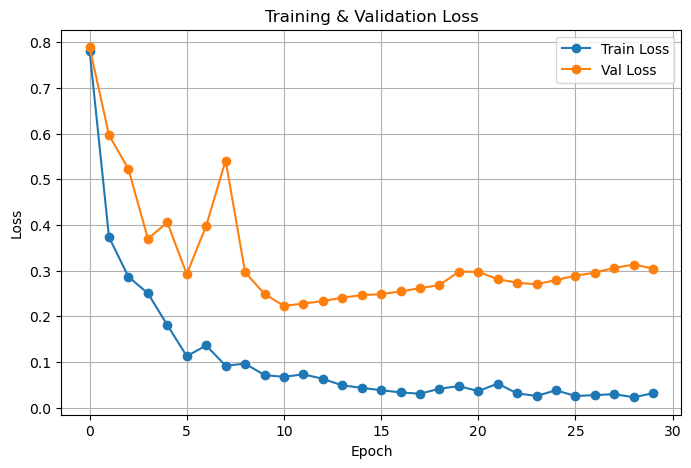

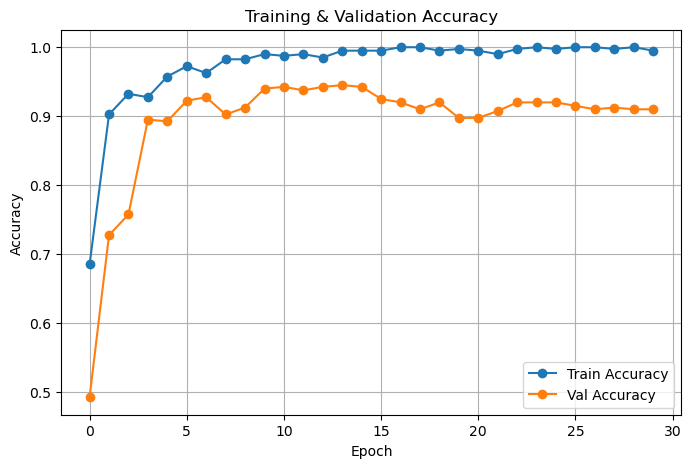

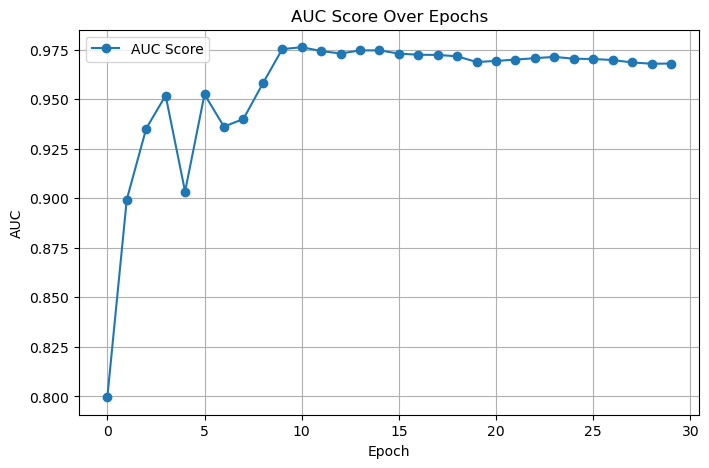

In [7]:
# Save training log CSV and checkpoint like before
training_epochs = list(range(1, len(train_losses) + 1))
df = pd.DataFrame({
    "epoch": training_epochs,
    "train_loss": train_losses,
    "train_acc": train_accs,
    "val_loss": val_losses,
    "val_acc": val_accs,
    "val_auc": auc_scores
})
training_log_path = os.path.join(SAVE_BASE, 'training_log.csv')
df.to_csv(training_log_path, index=False)
print("Saved training_log.csv")

best_path = os.path.join(SAVE_BASE, 'best_by_val_auc.pth')
torch.save(best_checkpoint, best_path)
print('Saved best-by-val-auc checkpoint to', best_path)

# Plot Loss / Accuracy / AUC
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Val Accuracy', marker='o')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(auc_scores, label='AUC Score', marker='o')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC Score Over Epochs'); plt.legend(); plt.grid(True)
plt.show()


Loaded best checkpoint for evaluation

Threshold search results on validation set (using checkpoint weights):
  Best by recall@FPR<=0.10: t=0.357, recall=0.9101

--- Validation metrics using threshold optimized for recall (t=0.357) ---
Accuracy: 0.9075
Precision: 0.7363636363636363
Recall: 0.9101123595505618
F1: 0.8140703517587939

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.91      0.94       311
        ARMD       0.74      0.91      0.81        89

    accuracy                           0.91       400
   macro avg       0.85      0.91      0.88       400
weighted avg       0.92      0.91      0.91       400

Confusion matrix:
 [[282  29]
 [  8  81]]


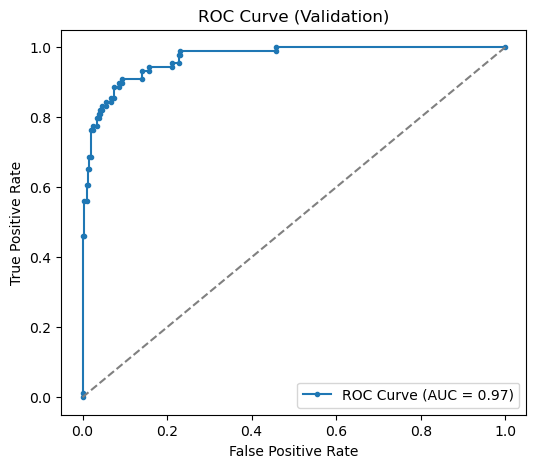


Done. Saved best and final checkpoints to C:\Users\asus\Desktop\Naami\Naamii Hackathon\Training And Validation\Checkpoints\Fourteenth_Model


In [8]:
# -----------------------
# Final evaluation and threshold search (unchanged)
# -----------------------
ck = torch.load(best_path, map_location=device, weights_only=True)
model.load_state_dict(ck)
print('Loaded best checkpoint for evaluation')

model.eval()
val_probs, val_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, non_blocking=PIN_MEMORY)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        val_probs.extend(probs.tolist())
        val_labels.extend(labels.numpy().astype(int).tolist())

val_probs = np.array(val_probs)
val_labels = np.array(val_labels).astype(int)

def evaluate_thresholds(labels: np.ndarray, probs: np.ndarray):
    fpr, tpr, roc_thresholds = roc_curve(labels, probs)
    specificity = 1.0 - fpr
    recall = tpr
    precision_at_thresh = []
    f1_scores = []
    N = labels.shape[0]
    pos = int(labels.sum())
    neg = N - pos
    for thr in roc_thresholds:
        preds = (probs >= thr).astype(int)
        tp = int(((preds == 1) & (labels == 1)).sum())
        fp = int(((preds == 1) & (labels == 0)).sum())
        fn = int(((preds == 0) & (labels == 1)).sum())
        tn = int(((preds == 0) & (labels == 0)).sum())
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
        precision_at_thresh.append(prec)
        f1_scores.append(f1)
    precision_at_thresh = np.array(precision_at_thresh)
    f1_scores = np.array(f1_scores)
    accuracy = (recall * pos + specificity * neg) / (pos + neg)
    return {
        "thresholds": np.array(roc_thresholds),
        "recall": np.array(recall),
        "specificity": np.array(specificity),
        "precision": precision_at_thresh,
        "f1": f1_scores,
        "fpr": np.array(fpr),
        "tpr": np.array(tpr),
        "accuracy": np.array(accuracy)
    }

MAX_ACCEPTABLE_FPR = 0.10
metrics = evaluate_thresholds(val_labels, val_probs)
mask = metrics['fpr'] <= MAX_ACCEPTABLE_FPR
if mask.any():
    candidate_recalls = metrics['recall'].copy()
    candidate_recalls[~mask] = -1.0
    best_rec_idx = int(np.argmax(candidate_recalls))
else:
    best_rec_idx = int(np.nanargmax(metrics['recall']))

best_rec_t, best_rec_val = float(metrics['thresholds'][best_rec_idx]), float(metrics['recall'][best_rec_idx])
print('\nThreshold search results on validation set (using checkpoint weights):')
print(f'  Best by recall@FPR<={MAX_ACCEPTABLE_FPR:.2f}: t={best_rec_t:.3f}, recall={best_rec_val:.4f}')

t = best_rec_t
preds = (val_probs >= t).astype(int)
print(f"\n--- Validation metrics using threshold optimized for recall (t={t:.3f}) ---")
print('Accuracy:', accuracy_score(val_labels, preds))
print('Precision:', precision_score(val_labels, preds, zero_division=0))
print('Recall:', recall_score(val_labels, preds, zero_division=0))
print('F1:', f1_score(val_labels, preds, zero_division=0))
print('\nClassification Report:')
print(classification_report(val_labels, preds, target_names=['Normal','ARMD'], zero_division=0))
cm = confusion_matrix(val_labels, preds)
print('Confusion matrix:\n', cm)

fpr_vals, tpr_vals, _ = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr_vals, tpr_vals)
plt.figure(figsize=(6,5))
plt.plot(fpr_vals, tpr_vals, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Validation)'); plt.legend(); plt.show()

print('\nDone. Saved best and final checkpoints to', SAVE_BASE)

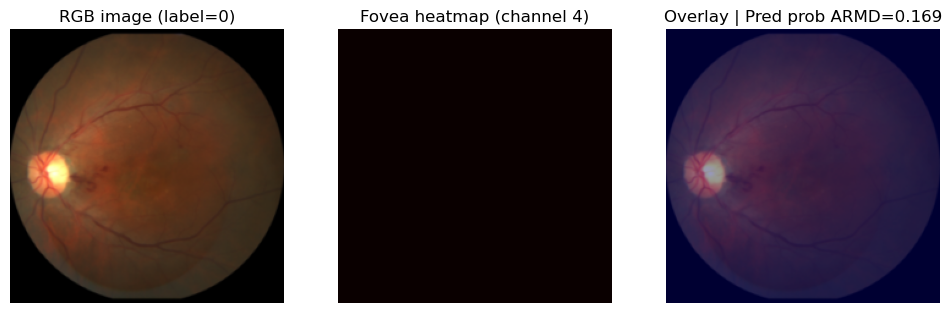

In [10]:
# -----------------------
# Visualization: show one validation image, its fovea heatmap and overlay + predicted prob
# -----------------------
def visualize_sample_with_heatmap(model, dataset, index=0):
    model.eval()
    img_tensor, label = dataset[index]  # img_tensor has shape (4,H,W)
    # separate
    rgb = img_tensor[:3,:,:].permute(1,2,0).cpu().numpy()  # HxWx3 normalized
    # de-normalize for display
    mean_arr = np.array(mean).reshape(1,1,3)
    std_arr = np.array(std).reshape(1,1,3)
    rgb = (rgb * std_arr + mean_arr)
    rgb = np.clip(rgb, 0.0, 1.0)
    heat = img_tensor[3,:,:].cpu().numpy()  # HxW

    # model prediction
    inp = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        prob = torch.sigmoid(out).cpu().numpy().flatten()[0]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(rgb)
    plt.title(f"RGB image (label={label})"); plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(heat, cmap='hot')
    plt.title("Fovea heatmap (channel 4)"); plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(rgb)
    plt.imshow(heat, cmap='jet', alpha=0.4)
    plt.title(f"Overlay | Pred prob ARMD={prob:.3f}"); plt.axis('off')
    plt.show()

# pick first sample from validation dataset for visualization
try:
    visualize_sample_with_heatmap(model, test_dataset, index=0)
except Exception as e:
    print("Visualization error:", e)
